In [1]:
# Load Kaggle API Token
from google.colab import files
!pip install -q kaggle > /dev/null
uploaded = files.upload()
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# Load Data
!kaggle competitions download -c tensorflow-speech-recognition-challenge > /dev/null

# Unzip Data
!apt-get install p7zip-full > /dev/null
!p7zip -d train.7z > /dev/null
# !p7zip -d test.7z > /dev/null


Saving kaggle.json to kaggle.json
100% 501k/501k [00:00<00:00, 75.6MB/s]
100% 1.04G/1.04G [00:13<00:00, 83.2MB/s]
100% 2.46G/2.46G [00:50<00:00, 52.6MB/s]
100% 50.0/50.0 [00:00<00:00, 49.8kB/s]


In [4]:
from scipy.io import wavfile
from IPython.display import Audio
from os import walk
from matplotlib import pyplot as plt

debug = True

train_audio_path = '/content/train/audio/'

# Load all filenames into a dictionary so we can call on them easily
files = {}
for (dirpath, dirnames, filenames) in walk(train_audio_path):
  files[dirpath[21:]] = filenames

if debug:
  # Look at a small part of the dictionary
  for label, samples in files.items():
    print(label, '\t', samples[0:5])

 	 []
five 	 ['38d78313_nohash_4.wav', '8fe52b97_nohash_1.wav', 'f804cbb3_nohash_0.wav', '833a0279_nohash_2.wav', 'd85270c1_nohash_2.wav']
marvin 	 ['bed06fac_nohash_1.wav', '8fe52b97_nohash_1.wav', '7be9f58a_nohash_0.wav', '27c30960_nohash_0.wav', 'e649aa92_nohash_0.wav']
nine 	 ['38d78313_nohash_4.wav', 'bed06fac_nohash_1.wav', '7be9f58a_nohash_0.wav', '43b85b64_nohash_1.wav', '5de8f2f0_nohash_2.wav']
up 	 ['38d78313_nohash_4.wav', '27c30960_nohash_0.wav', 'e649aa92_nohash_0.wav', 'c08e5058_nohash_0.wav', '1890e5c3_nohash_2.wav']
right 	 ['38d78313_nohash_4.wav', '8fe52b97_nohash_1.wav', 'eee9b9e2_nohash_2.wav', '7be9f58a_nohash_0.wav', 'e649aa92_nohash_0.wav']
six 	 ['38d78313_nohash_4.wav', 'bed06fac_nohash_1.wav', '8335f893_nohash_1.wav', '7be9f58a_nohash_0.wav', '27c30960_nohash_0.wav']
wow 	 ['bed06fac_nohash_1.wav', '8fe52b97_nohash_1.wav', '43b85b64_nohash_1.wav', '6823565f_nohash_2.wav', 'f804cbb3_nohash_0.wav']
down 	 ['38d78313_nohash_4.wav', 'a40c62f1_nohash_2.wav', '8335f

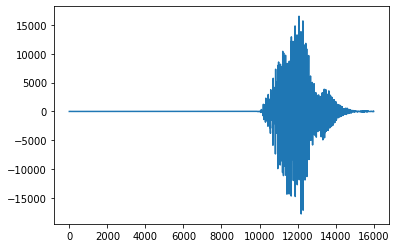

In [5]:
# Listen to and look at one audio sample of our choice
label = 'one'
sample_name = files[label][0]
sample_rate, sample = wavfile.read(train_audio_path + label + '/' + sample_name)

plt.plot(sample)
Audio(sample,rate=sample_rate)

In [18]:
import numpy as np
from keras.preprocessing import sequence
from sklearn.utils import shuffle
from scipy import signal

def onehot(A, mapping=None):
  if mapping is None:
    labels = set(A)
    mapping = {}

    for i, label in enumerate(labels):
      temp = [0] * len(labels)
      temp[i] = 1
      mapping[label] = temp
    
  res = []
  for label in A:
    res.append(mapping[label])
  
  return np.array(res), mapping

def normalize(x):
  minX = np.amin(x)
  maxX = np.amax(x)
  gap = maxX - minX

  print(minX, maxX, gap)
  return (x - (minX + 0.5*gap)) / (0.5 * gap)

def loadData(files):
  # Build Dataset
  xtrain, ytrain = [], []
  for label, filenames in files.items():
    if label not in ['', '_background_noise_']:
      for filename in filenames:
        sample_rate, sample = wavfile.read(train_audio_path + label + '/' + filename)

        resampled = signal.resample(sample, int(8000/sample_rate * sample.shape[0]))

        xtrain.append(resampled)

        
      ytrain.extend([label]*len(filenames))
  
  return xtrain, ytrain

def preprocess(xtrain, ytrain):
  # Ensuring all samples have the same length
  xtrain = sequence.pad_sequences(xtrain, maxlen=8000)

  # shuffle data
  xtrain, ytrain = shuffle(xtrain, ytrain)
  
  print("hi")
  # rescale all values between -1 and 1
  xtrain = normalize(xtrain)

  # reshaping data in preperation for LSTM
  xtrain = xtrain.reshape(xtrain.shape[0], 1, xtrain.shape[1])

  # Onehot encoding the output
  ytrain, mapping = onehot(ytrain)
  
  return xtrain, ytrain, mapping

In [ ]:
xtrain, ytrain = loadData(files)
xtrain, ytrain, mapping = preprocess(xtrain, ytrain)
print(xtrain.shape, ytrain.shape)

if debug:
  for map in mapping:
    print(map, '\t',mapping[map])  

hi
-49903 50925 100828


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Flatten

model = Sequential()
model.add(LSTM(32, return_sequences = True, input_shape = xtrain.shape[1:], activation = 'relu'))
model.add(LSTM(128, activation = 'relu'))

model.add(Dense(512, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))

model.add(Dense(len(mapping), activation = 'softmax'))
model.summary()

# Let's use the Adam optimizer for learning
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(xtrain, ytrain,
          batch_size=128, epochs=5,
          verbose=1,
          validation_split=0.2)